getting a feel for pipeline parallel inference

This trades off VRAM requirements per GPU for increased latency due to inter GPU communication (over PCIe in this setup). 
The GPU will be idle 50% of the time if you only process a single input, but that could be fine if per GPU VRAM is the main bottleneck.

results for this prompt and model:

- 1x 4090 -> 16GB VRAM, 2.21s inference time
- 2x 4090 -> 8GB VRAM each, 2.35s inference time


In [1]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True,device_map="auto",max_memory={0: "24GB"})

# split model across 2 GPUs

# prepare image and text prompt, using the appropriate prompt template
url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is shown in this image?"},
          {"type": "image"},
        ],
    },
]



Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST]  
What is shown in this image? [/INST] The image appears to be a radar chart, which is a type of multi-dimensional plot that displays values for multiple quantitative variables represented on axes starting from the same point. This particular radar chart is showing the performance of different models or systems across various metrics.

The axes represent different metrics or benchmarks, such as MM-Vet, MM-Vet, MM-Vet, MM-Vet, MM-Vet, MM-


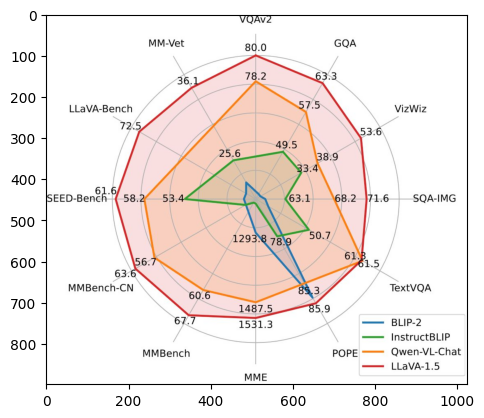

In [2]:
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100)

print(processor.decode(output[0], skip_special_tokens=True))

# show the image 
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

In [3]:
# benchmark the inference time  
import time
import tqdm

def benchmark(model, n_iters):
    # show model GPU config:
    print(model.hf_device_map)
    print(f" model has been loaded on {len(set(model.hf_device_map.values()))} GPUs")
    def run_inference():
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

        inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda:0")

        # autoregressively complete prompt
        output = model.generate(**inputs, max_new_tokens=100)

    n_iters = 10 

    timings = []
    for i in range(n_iters):
        start_time = time.time()
        run_inference()
        end_time = time.time()
        timings.append(end_time - start_time)

    print(f"Average inference time: {sum(timings) / n_iters} seconds")



In [4]:
benchmark(model, 10)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'': 0}
 model has been loaded on 1 GPUs


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Average inference time: 2.2151496171951295 seconds


In [5]:
# now delete the original model and reload on two GPUs:
import gc 
def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_peak_memory_stats()    


del model
flush()



/home/tlips/Code/few-shot-keypoints/.venv/lib/python3.12/site-packages/torch/cuda/memory.py:489: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [6]:
model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True,device_map="balanced",max_memory={0: "12GB", 1: "12GB"})

benchmark(model, 10)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'model.image_newline': 0, 'model.vision_tower': 0, 'model.multi_modal_projector': 0, 'model.language_model.embed_tokens': 0, 'model.language_model.layers.0': 0, 'model.language_model.layers.1': 0, 'model.language_model.layers.2': 0, 'model.language_model.layers.3': 0, 'model.language_model.layers.4': 0, 'model.language_model.layers.5': 0, 'model.language_model.layers.6': 0, 'model.language_model.layers.7': 0, 'model.language_model.layers.8': 0, 'model.language_model.layers.9': 0, 'model.language_model.layers.10': 0, 'model.language_model.layers.11': 0, 'model.language_model.layers.12': 0, 'model.language_model.layers.13': 0, 'model.language_model.layers.14': 0, 'model.language_model.layers.15': 1, 'model.language_model.layers.16': 1, 'model.language_model.layers.17': 1, 'model.language_model.layers.18': 1, 'model.language_model.layers.19': 1, 'model.language_model.layers.20': 1, 'model.language_model.layers.21': 1, 'model.language_model.layers.22': 1, 'model.language_model.layers.23':

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Average inference time: 2.3574053049087524 seconds
